In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import shutil
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
import pathlib
import functools
import time
from IPython import display

In [ ]:
# check GPU setup and mount google drive
from google.colab import drive
drive.mount('/content/drive')
tf.config.list_physical_devices('GPU')
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Fri May  7 18:10:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    24W / 300W |      2MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+------

In [ ]:
# Image augmentation to create more fire images
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation((-0.4, 0.4)),
])

# count the number of fire labels and non fire labels. 
def file_count(path):
    """Function to count images"""
    file_count = 0
    dirs = os.listdir(path)
    for dir in dirs:
      dir2 = path.joinpath(dir)  
      if os.path.isdir(dir2):
        file_count += len(os.listdir(dir2))
    return file_count


def evaluation(model, data):
    """Get predictions to a dataset"""
    prediction = tf.sigmoid(model.predict(data)).numpy()
    return prediction

def test_new_data(model):
    """Test a model on the new dataset and get error rate and accuracy"""
    new_data_prediction = evaluation(model, new_data)
    error_ratio = np.sum(new_data_prediction >= 0.5)/ new_data_prediction.shape[0]
    accuracy = np.sum(new_data_prediction < 0.5) / new_data_prediction.shape[0]
    print('The misclassification probability is', round(error_ratio, 2))
    print('The accuracy is', round(accuracy, 2))


def random_noise_plot(model):
  """Function to generate random images from a given generator"""
  samples = tf.random.normal([9, 640, 480, 3])
  plt.figure(figsize=(10,10))
  recon = model(samples)[-1]
  for i in range(recon.numpy().shape[0]):
    ax = plt.subplot(3, 3, i + 1)
    ax.imshow(recon[i].numpy().squeeze())


def acc_testset(model):
  test_data = np.stack(list(test_ds.map(lambda x,y: x).unbatch()))
  test_label = np.stack(list(test_ds.map(lambda x,y: y).unbatch()))
  test_prediction = model.predict(test_data)
  predictions = tf.where(tf.sigmoid(test_prediction).numpy().squeeze() >= 0.5, 1, 0)
  test_acc = np.mean(predictions == test_label.squeeze())
  print('The accuracy on the testing set is', np.round(test_acc, 4))

# Data preprocessing

In [ ]:
data_dir = pathlib.Path('/content/drive/MyDrive/Fire_recogntion_data/fire_test') 
fire_path = data_dir/'fire'
fire_image_count = file_count(data_dir/'fire')
nonfire_image_count = file_count(data_dir/'no_fire')
ratio = fire_image_count / nonfire_image_count
print('The number of fire images is', fire_image_count)
print('The number of non fire images is', nonfire_image_count)
print('The ratio of fire image to non-fire image is', round(ratio, 2))

The number of fire images is 1232
The number of non fire images is 1212
The ratio of fire image to non-fire image is 1.02


In [ ]:
img_height = 640
img_width = 480
batch_size = 32

# load all data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir, 
  seed=123, label_mode = 'int', class_names = ['no_fire', 'fire'],
  image_size=(img_height, img_width),
  batch_size = batch_size, validation_split = 0.2, subset = 'training'
  ).map(lambda x, y: (data_augmentation(x/255.), y) ).cache().prefetch(2)
train_size = train_ds.cardinality().numpy()
print('Train batches', train_size)


test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir, 
  seed=123, label_mode = 'int', class_names = ['no_fire', 'fire'],
  image_size=(img_height, img_width),
  batch_size = batch_size, validation_split = 0.2, subset = 'validation', 
  ).map(lambda x, y: (data_augmentation(x/255.), y) ).cache().prefetch(2)
test_size = test_ds.cardinality().numpy()
print('Test batches', test_size)

Found 2444 files belonging to 2 classes.
Using 1956 files for training.
Train batches 62
Found 2444 files belonging to 2 classes.
Using 488 files for validation.
Test batches 16


In [ ]:
# Load new data for testing prupose
new_data_path = '/content/drive/MyDrive/Fire_recogntion_data/test_data'
new_data = keras.preprocessing.image_dataset_from_directory(new_data_path, 
         label_mode = None, image_size=(img_height, img_width),
  batch_size = batch_size).map(lambda x: data_augmentation(x/255.) ).cache().prefetch(2)
new_data.cardinality().numpy()

Found 852 files belonging to 2 classes.


27

## Load pretrained models

### The autoencoder trained with only fire images

In [ ]:
fire_only_model_path = '/content/drive/MyDrive/Colab Notebooks/fire_project/fire_only_model'
pretrained_model = keras.models.load_model(fire_only_model_path)
pretrained_model.encoder.summary()
pretrained_model.decoder.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 320, 240, 12)      912       
_________________________________________________________________
batch_normalization_9 (Batch (None, 320, 240, 12)      48        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 160, 120, 24)      7224      
_________________________________________________________________
batch_normalization_10 (Batc (None, 160, 120, 24)      96        
_________________________________________________________________
48filter_layer (Conv2D)      (None, 80, 60, 48)        10416     
_________________________________________________________________
batch_normalization_11 (Batc (None, 80, 60, 48)        192       
_________________________________________________________________
72filter_layer (Conv2D)      (None, 40, 30, 72)       

### Load autoencoder trained with all images


In [ ]:
# load pretrained all_image model and check the structures
all_data_model_path = '/content/drive/MyDrive/Colab Notebooks/fire_project/all_data_model'
all_data_model = keras.models.load_model(all_data_model_path)
all_data_model.encoder.summary()
all_data_model.decoder.summary()

# get low level layers
trained_encoder = keras.models.clone_model(all_data_model.encoder)
trained_layers = trained_encoder.layers[-4:]
filter72, batch_normal1, filter96, batch_normal2 = trained_layers

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 320, 240, 12)      912       
_________________________________________________________________
batch_normalization_89 (Batc (None, 320, 240, 12)      48        
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 160, 120, 24)      7224      
_________________________________________________________________
batch_normalization_90 (Batc (None, 160, 120, 24)      96        
_________________________________________________________________
48filter_layer (Conv2D)      (None, 80, 60, 48)        10416     
_________________________________________________________________
batch_normalization_91 (Batc (None, 80, 60, 48)        192       
_________________________________________________________________
72filter_layer (Conv2D)      (None, 40, 30, 72)      

# CNN GAN

### Make the generator by using pretrained layers from fire autoencoder

In [ ]:
def make_generator():
  """Make a simple cnn generator to generate images from random noise"""
  n_filters=12
  input = keras.Input((100))
  x = layers.Dense(units=20 * 15* 8* n_filters)(input)
  x = layers.LeakyReLU(0.3)(x)
  x = layers.Reshape(target_shape=(20, 15, 8 * n_filters))(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(0.1)(x)
  output = pretrained_model.decoder(x)
  generator = keras.Model(input, output)
  return generator

In [ ]:
generator = make_generator()
generator.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_8 (Dense)              (None, 28800)             2908800   
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 28800)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 20, 15, 96)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 20, 15, 96)        384       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 20, 15, 96)        0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 640, 480, 3)       1119

### Make discriminator by using layers from all data model low level layers

In [ ]:
def build_discriminator():
    """A discriminator to classify images, use lower level layer from 
    a trained autoencoder"""
    n_filters = 12
    Conv2D = functools.partial(layers.Conv2D, padding='same', activation='relu')
    BatchNormalization = layers.BatchNormalization
    cnn_model = tf.keras.Sequential([
        # Define the first convolutional layer
        layers.Input(shape=(640, 480, 3), name='input'),
        Conv2D(filters=1*n_filters, kernel_size=5,  strides=2),
        BatchNormalization(),
        
        Conv2D(filters=2*n_filters, kernel_size=5,  strides=2),
        BatchNormalization(),

        Conv2D(filters=4*n_filters, kernel_size=3,  strides=2),
        BatchNormalization(),
        layers.MaxPool2D(pool_size=(3, 3), strides=1, padding='same'),

        filter72, batch_normal1, filter96, batch_normal2,

        # Define the max pooling layer   
        layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='same'),

        layers.Flatten(),
        layers.Dense(128, activation='relu', 
                     kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        layers.Dropout(0.2),
        layers.BatchNormalization(),
        layers.Dense(32, activation='relu', 
                     kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        layers.BatchNormalization(),
        layers.Dense(1)        
    ])
    
    return cnn_model

In [ ]:
discriminator = build_discriminator()

### Compile the model by defining loss function, optimizer and customized training steps

In [ ]:
# define loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(1e-4) 
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
def discriminator_loss(real_output, fake_output, y):
    """Loss of discriminator is made by loss of real images and generated fire images
    real loss is the loss between y and ylogit
    fake loss is the loss between 0 and fake output because we need to penalize non-zero 
    predictions of discriminator
    """
    real_loss = cross_entropy(y, real_output) 
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    """Simply penalize none-zero output"""
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
# generate samples fro the generator
noise_dim = 100
num_examples_to_generate = 16
# reuse this seed overtime
seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [ ]:
# Notice the use of `tf.function` to wrap up my function
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images, labels):
    """define the training loop"""
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output, labels)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [ ]:
# define a tracker
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
def train(dataset, epochs):
    """Training loop by calling the train_step function, return losses of both 
    generator and discriminator"""
    for epoch in range(epochs):
        start = time.time()

        for image_batch, labels in dataset:
            gen_loss, disc_loss = train_step(image_batch, labels)

      # Save the model every 15 epochs
        if epoch % 10 == 0:
          checkpoint.save(file_prefix = checkpoint_prefix)
          print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
          print('Generator loss %.4f, discriminator loss %.4f' % (gen_loss, disc_loss) )
          print()

    # Generate after the final epoch
    #display.clear_output(wait=True)

In [ ]:
train(train_ds, 170)

Time for epoch 1 is 17.862688541412354 sec
Generator loss 0.8623, discriminator loss 1.0242

Time for epoch 11 is 12.596266746520996 sec
Generator loss 1.0498, discriminator loss 0.5242

Time for epoch 21 is 12.594899892807007 sec
Generator loss 1.4419, discriminator loss 0.2958

Time for epoch 31 is 12.613428354263306 sec
Generator loss 1.9840, discriminator loss 0.1561

Time for epoch 41 is 12.58735704421997 sec
Generator loss 2.5605, discriminator loss 0.0842

Time for epoch 51 is 12.583153009414673 sec
Generator loss 3.1045, discriminator loss 0.0488

Time for epoch 61 is 12.657640933990479 sec
Generator loss 3.6087, discriminator loss 0.0299

Time for epoch 71 is 12.598208904266357 sec
Generator loss 4.0664, discriminator loss 0.0195

Time for epoch 81 is 12.590429544448853 sec
Generator loss 4.4379, discriminator loss 0.0137

Time for epoch 91 is 12.608942747116089 sec
Generator loss 4.8251, discriminator loss 0.0091

Time for epoch 101 is 12.589802503585815 sec
Generator loss 5.

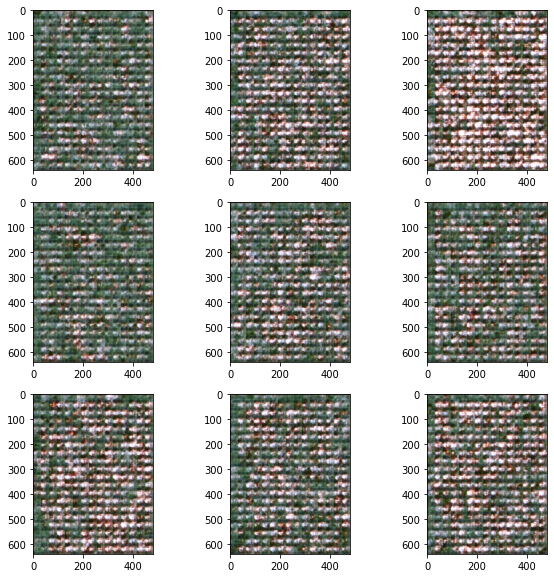

In [ ]:
# check the output of generator after training
samples = tf.random.normal([9, 100])
plt.figure(figsize=(10,10))
recon = generator(samples)
for i in range(recon.numpy().shape[0]):
  ax = plt.subplot(3, 3, i + 1)
  ax.imshow(recon[i].numpy().squeeze())

### test the discriminator on the test dataset

In [ ]:
# test on test dataset
acc_testset(discriminator)

The accuracy on the testing set is 0.9324


In [ ]:
# test on new dataset
test_new_data(discriminator)

The misclassification probability is 0.05
The accuracy is 0.95


# VAE GAN


In [ ]:
# load VAE model
generator2 = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/fire_project/VAE_model')

In [ ]:
# make another discriminator
discriminator2 = build_discriminator()

In [ ]:
# get a sample batch from training data as input to the VAE generator
noise = np.stack(list(train_ds.take(1).map(lambda x,y: x))).squeeze()

In [ ]:
@tf.function
def train_step(images, labels):
    #noise = tf.random.normal([num_examples_to_generate, 640, 480, 3])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator2(noise, training=True)[-1]

      real_output = discriminator2(images, training=True)
      fake_output = discriminator2(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output, labels)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator2.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator2.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator2.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator2.trainable_variables))

    return gen_loss, disc_loss

In [ ]:
def train2(dataset, epochs):
    """Training loop by calling the train_step function, return losses of both 
    generator and discriminator"""
    for epoch in range(epochs):
        start = time.time()

        for image_batch, labels in dataset:
          gen_loss, disc_loss = train_step(image_batch, labels)

      # Save the model every 15 epochs
        if epoch % 10 == 0:
          print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
          print('Generator loss %.4f, discriminator loss %.4f' % (gen_loss, disc_loss) )
          print()

In [ ]:
train2(train_ds, 200)

Time for epoch 1 is 148.24843335151672 sec
Generator loss 0.7623, discriminator loss 1.6011

Time for epoch 11 is 10.071329593658447 sec
Generator loss 1.0077, discriminator loss 0.5691

Time for epoch 21 is 10.056758403778076 sec
Generator loss 1.4528, discriminator loss 0.3450

Time for epoch 31 is 10.06344199180603 sec
Generator loss 2.0152, discriminator loss 0.1954

Time for epoch 41 is 10.100488185882568 sec
Generator loss 2.6094, discriminator loss 0.1286

Time for epoch 51 is 10.058905363082886 sec
Generator loss 3.1727, discriminator loss 0.1127

Time for epoch 61 is 10.070842504501343 sec
Generator loss 3.6853, discriminator loss 0.0605

Time for epoch 71 is 10.06773066520691 sec
Generator loss 4.1142, discriminator loss 0.0815

Time for epoch 81 is 10.05806565284729 sec
Generator loss 4.5161, discriminator loss 0.0411

Time for epoch 91 is 10.077112436294556 sec
Generator loss 4.8930, discriminator loss 0.0382

Time for epoch 101 is 10.100018501281738 sec
Generator loss 5.25

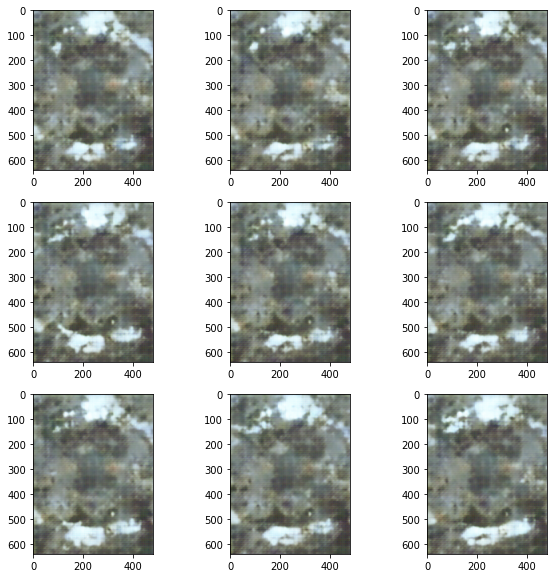

In [ ]:
# plot 9 images generated from random noise
random_noise_plot(generator2)

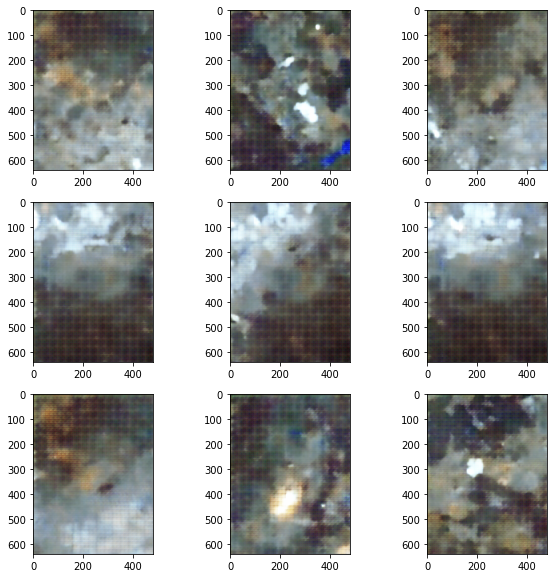

In [ ]:
# plot 9 samples from input batch
samples = noise[:9, ...]
plt.figure(figsize=(10,10))
recon = generator2(samples)[-1]
for i in range(recon.numpy().shape[0]):
  ax = plt.subplot(3, 3, i + 1)
  ax.imshow(recon[i].numpy().squeeze())

In [ ]:
# test on new data
test_new_data(discriminator2)

The misclassification probability is 0.03
The accuracy is 0.97


In [ ]:
# test on test dataset
acc_testset(discriminator2)

The accuracy on the testing set is 0.9303


In [ ]:
# save the discriminator
discriminator2.save('/content/drive/MyDrive/Colab Notebooks/fire_project/VAE_discriminator')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/fire_project/VAE_discriminator/assets
